In [2]:
%matplotlib inline
%qtconsole

import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap

from datetime import datetime, timedelta
from scipy import stats

import xarray as xr

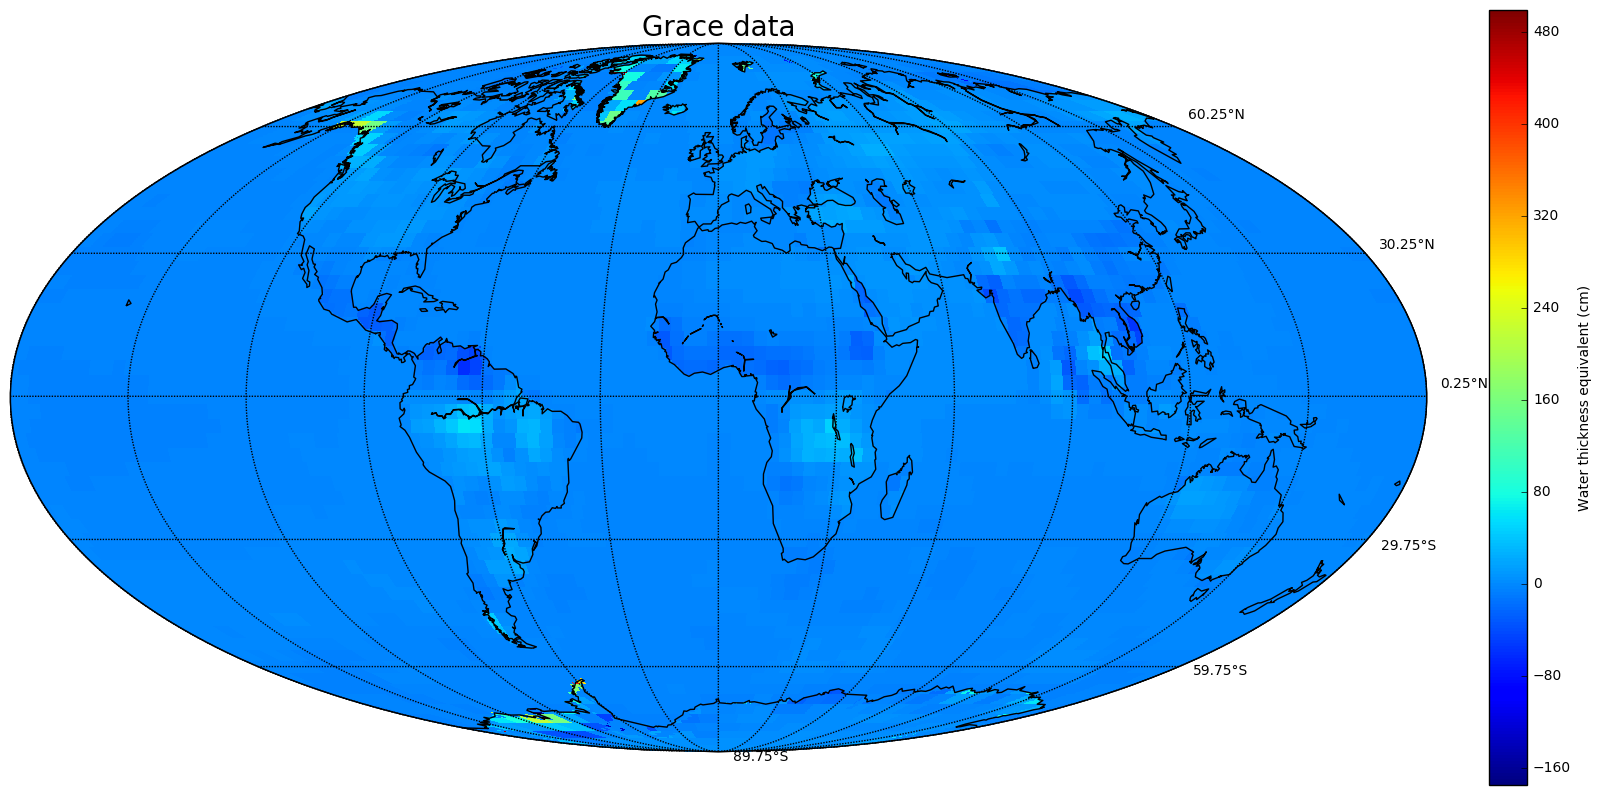

In [3]:
#url = 'http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/land_mass/RL05/netcdf/GRCTellus.JPL.200204_201607.LND.RL05_1.DSTvSCS1411.nc'
nc = 'http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/mascon/RL05/JPL/CRI/netcdf/GRCTellus.JPL.200204_201606.GLO.RL05M_1.MSCNv02CRIv02.nc'
data = xr.open_dataset(nc)
rmap = data['lwe_thickness'][0,:,:]

# Extract Lat/Lon Metadata
lat_min = data.geospatial_lat_min
lat_max = data.geospatial_lat_max
lat_res = float(data.geospatial_lat_resolution[0:3])

lon_min = data.geospatial_lon_min
lon_max = data.geospatial_lon_max
lon_res = float(data.geospatial_lon_resolution[0:3])

# Build grid
lon_g = np.arange(lon_min,lon_max+lon_res,lon_res)
lat_g = np.arange(lat_min,lat_max+lat_res,lat_res)
x,y = np.meshgrid(lon_g[:], lat_g[:])

# Plot Fig
plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw parallels and meridians.
parallels = np.arange(-89.75,89.75,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',latlon=True)
m.drawcoastlines();
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Water thickness equivalent (cm)')
plt.title('Grace data',size=20)


In [22]:
# use pd.read_csv to read in the csv data
csv = 'https://www.hydroshare.org/django_irods/download/d3659dcf575d4090801a74d1ce096d7c/data/contents/WPDx_Well_Function_Upd_151224_xy161117.csv'
wells = pd.read_csv(csv)

# Make a map with some property scattered over

In [12]:
# 1. Code that subselects regions of interest. This is for all of Africa, but could be used later to get individual time series

data = xr.open_dataset('http://opendap.jpl.nasa.gov:80/opendap/GeodeticsGravity/tellus/L3/mascon/RL05/JPL/CRI/netcdf/GRCTellus.JPL.200204_201606.GLO.RL05M_1.MSCNv02CRIv02.nc')

af = xr.concat( [data['lwe_thickness'].isel(time=0).sel(lat=slice(-37.75,37.75)).sel(lon=slice(340.25,359.75)),
                  data['lwe_thickness'].isel(time=0).sel(lat=slice(-37.75,37.75)).sel(lon=slice(0.25,50.75))],
                  dim='lon')

af.shape

lonaf = xr.concat( [data['lon'].sel(lon=slice(340.25,359.75)),
                  data['lon'].sel(lon=slice(0.25,50.75))],
                  dim='lon')

lataf = data['lat'].sel(lat=slice(-37.75,37.75))


In [103]:
# Find nearest grid locations for all data
# lon_g and lat_g are the lons and lats of the gridded products, respectively

lon_g = lonaf
lat_g = lataf

xRes = np.median(np.diff(lon_g))
yRes = np.median(np.diff(lat_g))

# Define grid box centers
lon_c = lon_g[:-1]+xRes/2
lat_c = lat_g[:-1]+yRes/2

# Define a new metadata file that has grid coordinates for this resolution choice
wg = wells

wg.loc[:,'grid_lat'] = np.nan
wg.loc[:,'grid_lon'] = np.nan

## Determine grid_lat and grid_lon for every record

for index, row in wg.iterrows():
    lon_s = row[u'LONG_DD']
    lat_s = row[u'LAT_DD']
    # correct for wrapping
    if lon_s<0:
        lon_s = 360+lon_s
    glat = lat_g.values[np.argmin(np.abs(lat_c.values-lat_s))]
    glon = lon_g.values[np.argmin(np.abs(lon_c.values-lon_s))]
    wg.set_value(index,'grid_lat',glat)
    wg.set_value(index,'grid_lon',glon)

WELL_ID     LAT_DD    LONG_DD     FUNC  \
0       362092   5.982436  -8.180609      Yes   
1       362100   5.899207  -8.173315      Yes   
2       357349   5.802157  -9.645714      Yes   
3       489514  -0.541100  34.375820       No   
4       357595   5.716055  -9.618187       No   
5       489266  -0.730000  34.366000       No   
6       489625  -0.450333  34.009880       No   
7       364570   5.231378  -9.141873      Yes   
8       361779   5.225134  -8.121493      Yes   
9       361780   5.225422  -8.119787      Yes   
10      365177   5.190745  -9.043733      Yes   
11      489624  -0.480917  34.009890       No   
12      359723   5.020838  -7.660045       No   
13      365567   4.994706  -7.896630      Yes   
14      359873   6.386340 -10.755959      Yes   
15      359934   6.379438 -10.775051      Yes   
16      363124   6.334777 -10.792682      Yes   
17      362739   6.333671 -10.785141      Yes   
18      366595   6.329771 -10.755218      Yes   
19      366548   6.328716 -10.755411      Yes   
20      363676   6.310975 -10.798569      Yes   
21      364879   6.307755 -10.799409      Yes   
22      489544  -0.550333  34.387750       No   
23      489510  -0.530250  34.349920       No   
24      489698  -0.521000  34.275530       No   
25      489716  -0.733517  34.190250      Yes   
26      489474  -0.631300  34.459320      Yes   
27      359736   4.645290  -7.582768      Yes   
28      489357  -0.650850  34.406880      Yes   
29      489358  -0.642433  34.394130      Yes   
...        ...        ...        ...      ...   
17981   490728   1.759500  32.375187       No   
17982   490093   1.820680  32.466522       No   
17983   490997   1.848909  32.513946       No   
17984   490730   2.053498  32.644738       No   
17985   490435   1.733558  32.496951       No   
17986   490439   1.730313  32.468445       No   
17987   490440   1.776072  32.458147       No   
17988   490434   1.733324  32.496994       No   
17989   489847   1.866083  32.719903       No   
17990   490214   1.997437  32.847491       No   
17991   489981   1.700627  32.396367       No   
17992   489940   2.088080  32.823175       No   
17993   490881   1.912940  32.862696       No   
17994   489947   1.919767  32.706646       No   
17995   490488   2.020943  32.369416       No   
17996   490747   1.668321  32.541246       No   
17997   490105   2.125865  32.540418       No   
17998   490814   1.866107  32.900753       No   
17999   490288   1.746125  32.419225       No   
18000   489919   1.851014  32.731565       No   
18001   483831  59.278134  18.015202  missing   
18002   483375   8.675615  16.840204  missing   
18003   483695   7.867364   3.961383  missing   
18004   484333   7.597172   5.230582  missing   
18005   483321  -2.511946  32.900248  missing   
18006   483841   7.408475   4.064835  missing   
18007   483900   7.408560   4.064823  missing   
18008   490128   2.042674  32.745330       No   
18009        0   0.000000   0.000000      NaN   
18010        0   0.000000   0.000000      NaN   

                                                  STATUS  COD_FCN  COD_QTY  \
0      Working but with problems. Well polluted|Under...        2        1   
1      Working but with problems. Well polluted|Under...        2        1   
2                 Working but with problems. Not priming        2        1   
3                 Drought|No operation in the dry season      999        0   
4                    Broken Down System. low water table        0        1   
5              No fuel|No operation at least once a week        2        1   
6               Low yield|No operation in the dry season        2        1   
7      Working but with problems. Well polluted|Under...        2        1   
8          Working but with problems. insufficient water        2        1   
9          Working but with problems. insufficient water        2        1   
10               Working but with problems. low pressure        2        1   
11     Equipment not-function|No